# Application to Metasurfaces and Lenses



In [ ]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, exp, tan, log,log10
from mplcursors import cursor  # separate package must be installed

from bookfuncs.py.simuParams import  SimuParam
from bookfuncs.py.PlotData.plotfunc import *

import skrf as rf

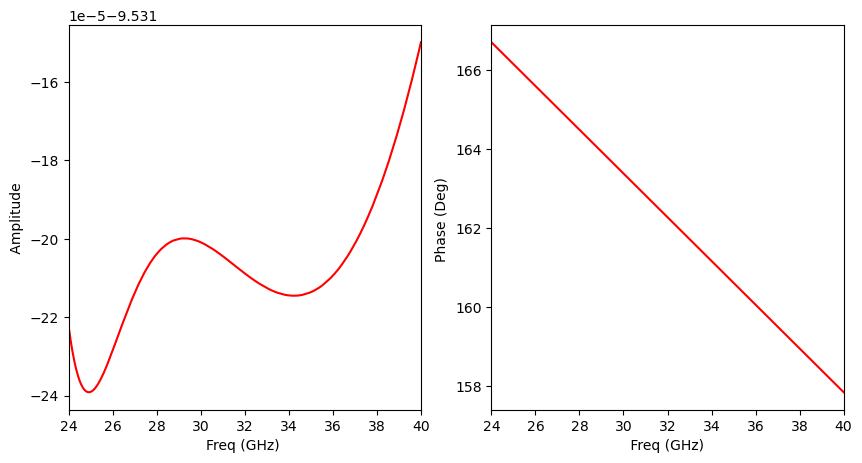

In [11]:
#https://community.altair.com/discussion/33258/a-metamaterial-inspired-single-split-ring-resonator-for-sensing-applications-a-practical-design-approach#:~:text=Split%20ring%20resonators%20(SRR)%20consists%20of%20two,can%20be%20represented%20by%20the%20following%20equation.

sheetR376_abLo4 = rf.Network("CSTFiles/UnitCell/Sheet_R376_1.s4p")


S11=np.squeeze(sheetR376_abLo4.s11.s)
S21=np.squeeze(sheetR376_abLo4.s31.s)
S12=np.squeeze(sheetR376_abLo4.s31.s)
S22=np.squeeze(sheetR376_abLo4.s33.s)

f=sheetR376_abLo4.f
a=np.array([[S11,S12],
            [S21,S22]])
SparYPol=np.transpose(a)
ABCDYPol=rf.s2a(SparYPol,z0=376.73)
fig2,ax=plt.subplots(1,2)
fig2.set_size_inches((10,5))

plot1DSparametricdB(ax,f,[24,40],(0,S11,'r','-') )


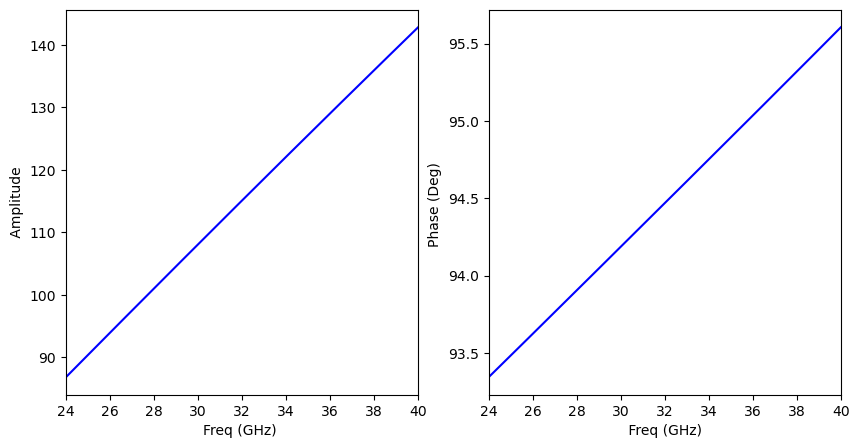

In [12]:
fig2,ax=plt.subplots(1,2)
fig2.set_size_inches((10,5))
plot1DSparametricMag(ax,f,[24,40],(0,ABCDYPol[:,0,1],'b','-'),
                       )

In [10]:
sheetR376_abLo4


4-Port Network: 'Sheet_R376_1',  24.0-40.0 GHz, 1001 pts, z0=[376.73+0.j 376.73+0.j 376.73+0.j 376.73+0.j]